In [80]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from binance.client import Client
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

import config


In [81]:
dateTimeFormat = '%d/%m/%Y %H:%M:%S'
startDateTimeStr = '01/01/2021 00:00:00'
endDateTimeStr = '31/01/2021 23:59:59'

startDateTime = datetime.strptime(startDateTimeStr, dateTimeFormat)
# sum 31 days to startDate
# endDateTime = startDateTime + datetime.timedelta(days = 31)
# OR specify date , keep in mind api let 90 days ahead.
endDateTime = datetime.strptime(endDateTimeStr, dateTimeFormat)
# must convert to millis , API Bug: https://github.com/sammchardy/python-binance/issues/419
startDateTimeMillis = int(startDateTime.timestamp()*1000)
endDateTimeMillis =int(endDateTime.timestamp()*1000)

client = Client(config.API_KEY, config.API_SECRET, tld='com')
df = client.get_klines(symbol='ETHBRL', interval=Client.KLINE_INTERVAL_1DAY, startTime=startDateTimeMillis,endTime=endDateTimeMillis)

df = pd.DataFrame(df)
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades',
              'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'Ignore']
#Manipulação dos dados recebidos pelo api 
# df.set_index('date', inplace=True)
# df.index = pd.to_datetime(df.index, unit='ms')

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df['open'] = pd.to_numeric(df['open'])
df['high'] = pd.to_numeric(df['high'])
df['low'] = pd.to_numeric(df['low'])
df['close'] = pd.to_numeric(df['close'])
df['volume'] = pd.to_numeric(df['volume'])

#Excluir colunas do df
df.drop('close_time', axis=1, inplace=True)
df.drop('quote_asset_volume', axis=1, inplace=True)
df.drop('number_of_trades', axis=1, inplace=True)
df.drop('taker_buy_base_asset_volume', axis=1, inplace=True)
df.drop('taker_buy_quote_asset_volume', axis=1, inplace=True)
df.drop('Ignore', axis=1, inplace=True)
df_ori = df
df.head()

,date,open,high,low,close,volume
0,1970-01-01 00:26:44.016000,2237.00,2237.36,788.00,2227.54,15.08916
1,1970-01-01 00:26:44.102400,2239.41,2277.43,2232.99,2246.94,9.98547
2,1970-01-01 00:26:44.188800,2260.99,2309.24,2242.52,2298.30,7.91028
3,1970-01-01 00:26:44.275200,2309.24,2339.22,2212.28,2229.99,73.56145
4,1970-01-01 00:26:44.361600,2215.30,2264.83,2176.35,2259.32,20.94825


In [82]:
df = df.drop(['open', 'high', 'low', 'volume'], axis=1)
df

,date,close
0,1970-01-01 00:26:44.016000,2227.54
1,1970-01-01 00:26:44.102400,2246.94
2,1970-01-01 00:26:44.188800,2298.30
3,1970-01-01 00:26:44.275200,2229.99
4,1970-01-01 00:26:44.361600,2259.32
...,...,...
309,1970-01-01 00:27:10.713600,20298.85
310,1970-01-01 00:27:10.800000,20552.10
311,1970-01-01 00:27:10.886400,20483.93
312,1970-01-01 00:27:10.972800,18200.00


In [83]:
df = df.set_index(pd.DatetimeIndex(df['date'].values))

df

,date,close
1970-01-01 00:26:44.016000,1970-01-01 00:26:44.016000,2227.54
1970-01-01 00:26:44.102400,1970-01-01 00:26:44.102400,2246.94
1970-01-01 00:26:44.188800,1970-01-01 00:26:44.188800,2298.30
1970-01-01 00:26:44.275200,1970-01-01 00:26:44.275200,2229.99
1970-01-01 00:26:44.361600,1970-01-01 00:26:44.361600,2259.32
...,...,...
1970-01-01 00:27:10.713600,1970-01-01 00:27:10.713600,20298.85
1970-01-01 00:27:10.800000,1970-01-01 00:27:10.800000,20552.10
1970-01-01 00:27:10.886400,1970-01-01 00:27:10.886400,20483.93
1970-01-01 00:27:10.972800,1970-01-01 00:27:10.972800,18200.00


In [84]:
df.drop('date', axis=1, inplace=True)
df

,close
1970-01-01 00:26:44.016000,2227.54
1970-01-01 00:26:44.102400,2246.94
1970-01-01 00:26:44.188800,2298.30
1970-01-01 00:26:44.275200,2229.99
1970-01-01 00:26:44.361600,2259.32
...,...
1970-01-01 00:27:10.713600,20298.85
1970-01-01 00:27:10.800000,20552.10
1970-01-01 00:27:10.886400,20483.93
1970-01-01 00:27:10.972800,18200.00


Text(0.5, 0, 'date')

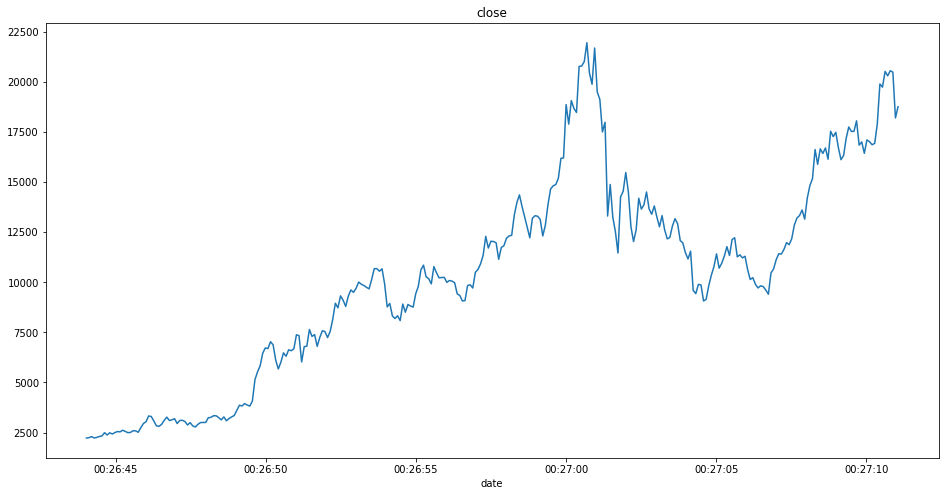

In [85]:
plt.figure(figsize=(16, 8))
plt.title('close')
plt.plot(df['close'])
plt.xlabel('date')

In [86]:
qtd_linhas = len(df)
qtd_linhas_treino = round(.70 * qtd_linhas)
qtd_linhas_teste = qtd_linhas - qtd_linhas_treino
info = (
    f"linhas treino= 0:{qtd_linhas_treino}"
    f"linhas teste= {qtd_linhas_treino}:{qtd_linhas_teste + qtd_linhas_treino}"
)
info

'linhas treino= 0:220linhas teste= 220:314'

In [87]:
#Normalizando os dados
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

In [88]:
#separando em treino e test
train = df_scaled[:qtd_linhas_treino]
test = df_scaled[qtd_linhas_treino: qtd_linhas_treino + qtd_linhas_teste]
print(len(train), len(test))

220 94


In [89]:
#converter em array
def create_df(df, steps=1):
    dataX, dataY = [], []
    for i in range(len(df) - steps - 1):
        a = df[i:(i + steps), 0]
        dataX.append(a)
        dataY.append(df[i + steps, 0])
    return np.array(dataX), np.array(dataY)

In [90]:
#gerar dados de treino e test
steps = 15
X_train, Y_train = create_df(train, steps)
X_test, Y_test = create_df(test, steps)

In [91]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(204, 15)
(204,)
(78, 15)
(78,)


In [92]:
#gerando dados que o modelo espea
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [93]:
#camade de rede neural
model = Sequential()
model.add(LSTM(35, return_sequences=True, input_shape=(steps, 1)))
model.add(LSTM(35, return_sequences=True))
model.add(LSTM(35))
model.add(Dropout(0.2))
model.add(Dense(1))

In [94]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 15, 35)            5180      
_________________________________________________________________
lstm_10 (LSTM)               (None, 15, 35)            9940      
_________________________________________________________________
lstm_11 (LSTM)               (None, 35)                9940      
_________________________________________________________________
dropout_3 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 36        
Total params: 25,096
Trainable params: 25,096
Non-trainable params: 0
_________________________________________________________________


In [95]:
#treinamento do modelo
validation = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=15, verbose=2)

Epoch 1/100
14/14 - 8s - loss: 0.4951 - val_loss: 0.2808
Epoch 2/100
14/14 - 1s - loss: 0.1718 - val_loss: 0.1485
Epoch 3/100
14/14 - 1s - loss: 0.1290 - val_loss: 0.1552
Epoch 4/100
14/14 - 1s - loss: 0.1185 - val_loss: 0.1750
Epoch 5/100
14/14 - 1s - loss: 0.1140 - val_loss: 0.1471
Epoch 6/100
14/14 - 1s - loss: 0.1004 - val_loss: 0.1375
Epoch 7/100
14/14 - 1s - loss: 0.1070 - val_loss: 0.1511
Epoch 8/100
14/14 - 1s - loss: 0.1121 - val_loss: 0.1205
Epoch 9/100
14/14 - 1s - loss: 0.0940 - val_loss: 0.1094
Epoch 10/100
14/14 - 1s - loss: 0.0835 - val_loss: 0.1167
Epoch 11/100
14/14 - 1s - loss: 0.0787 - val_loss: 0.0841
Epoch 12/100
14/14 - 1s - loss: 0.0739 - val_loss: 0.0902
Epoch 13/100
14/14 - 1s - loss: 0.0612 - val_loss: 0.1193
Epoch 14/100
14/14 - 1s - loss: 0.0617 - val_loss: 0.0703
Epoch 15/100
14/14 - 1s - loss: 0.0607 - val_loss: 0.0759
Epoch 16/100
14/14 - 1s - loss: 0.0521 - val_loss: 0.0792
Epoch 17/100
14/14 - 1s - loss: 0.0533 - val_loss: 0.0669
Epoch 18/100
14/14 - 1s

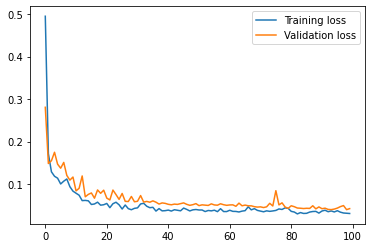

In [96]:
plt.plot(validation.history['loss'], label='Training loss')
plt.plot(validation.history['val_loss'], label='Validation loss')
plt.legend()

In [97]:
#fazendo a previsao 
prev = model.predict(X_test)
prev = scaler.inverse_transform(prev)
prev

array([[11563.462 ],
       [11074.495 ],
       [10667.415 ],
       [10370.013 ],
       [10112.69  ],
       [ 9898.859 ],
       [ 9801.376 ],
       [ 9852.275 ],
       [10046.837 ],
       [10387.4795],
       [10687.515 ],
       [10901.194 ],
       [11072.345 ],
       [11265.502 ],
       [11392.881 ],
       [11575.948 ],
       [11794.172 ],
       [11863.777 ],
       [11819.35  ],
       [11711.005 ],
       [11597.619 ],
       [11419.978 ],
       [11161.684 ],
       [10900.247 ],
       [10643.764 ],
       [10419.736 ],
       [10248.635 ],
       [10129.7705],
       [10033.449 ],
       [ 9941.901 ],
       [ 9961.817 ],
       [10101.943 ],
       [10364.813 ],
       [10696.426 ],
       [11016.287 ],
       [11295.523 ],
       [11558.342 ],
       [11765.103 ],
       [11940.049 ],
       [12182.391 ],
       [12509.421 ],
       [12868.119 ],
       [13234.192 ],
       [13476.97  ],
       [13759.944 ],
       [14158.812 ],
       [14661.343 ],
       [15422

In [98]:
#previsao para od proximos dias
lenght_test = len(test)
lenght_test

94

In [99]:
#pegando os ultimos dias do tamanho do meu step 
days_input_steps = lenght_test - steps
days_input_steps

79

In [100]:
#transforma em array
input_steps = test[days_input_steps:]
input_steps = np.array(input_steps).reshape(1, -1)
input_steps

array([[1.33285038, 1.21997515, 1.35277246, 1.33483406, 1.30452743,
        1.31898646, 1.51074859, 1.90596662, 1.87527119, 2.03093435,
        1.98699192, 2.03722856, 2.02370583, 1.57064772, 1.68128338]])

In [101]:
#tranformando em lista
list_output_steps = list(input_steps)
list_output_steps = list_output_steps[0].tolist()
list_output_steps

[1.3328503831984755,
 1.2199751529810554,
 1.3527724586452707,
 1.334834060928914,
 1.3045274325632727,
 1.31898645954044,
 1.5107485857419438,
 1.9059666183658872,
 1.87527118916508,
 2.030934348028061,
 1.986991918943384,
 2.037228557466743,
 2.0237058263783427,
 1.570647718490269,
 1.6812833765500237]

In [102]:
#loop para prever os proximos dias
pred_output = []
i = 0
n_future = 10
while (i < n_future):
    if (len(list_output_steps) > steps):

        input_steps = np.array(list_output_steps[1:])

        print("{} dia, valores de entrada -> {}".format(i, input_steps))
        input_steps = input_steps.reshape(1, -1)
        input_steps = input_steps.reshape((1, steps, 1))
        # print(input_steps)
        pred = model.predict(input_steps, verbose=0)
        print("{} dia, valores de entrada -> {}".format(i, pred))
        list_output_steps.extend(pred[0].tolist())
        list_output_steps = list_output_steps[1:]
        # print(list_output_steps)
        pred_output.extend(pred.tolist())
        i = i + 1
    else:
        input_steps = input_steps.reshape((1, steps, 1))
        pred = model.predict(input_steps, verbose=0)
        print(pred[0])
        list_output_steps.extend(pred[0].tolist())
        print(len(list_output_steps))
        pred_output.extend(pred.tolist())
        i = i + 1
print(pred_output)

[1.617896]
16
1 dia, valores de entrada -> [1.21997515 1.35277246 1.33483406 1.30452743 1.31898646 1.51074859
 1.90596662 1.87527119 2.03093435 1.98699192 2.03722856 2.02370583
 1.57064772 1.68128338 1.61789596]
1 dia, valores de entrada -> [[1.3762263]]
2 dia, valores de entrada -> [1.35277246 1.33483406 1.30452743 1.31898646 1.51074859 1.90596662
 1.87527119 2.03093435 1.98699192 2.03722856 2.02370583 1.57064772
 1.68128338 1.61789596 1.37622631]
2 dia, valores de entrada -> [[1.1611027]]
3 dia, valores de entrada -> [1.33483406 1.30452743 1.31898646 1.51074859 1.90596662 1.87527119
 2.03093435 1.98699192 2.03722856 2.02370583 1.57064772 1.68128338
 1.61789596 1.37622631 1.16110265]
3 dia, valores de entrada -> [[0.9810353]]
4 dia, valores de entrada -> [1.30452743 1.31898646 1.51074859 1.90596662 1.87527119 2.03093435
 1.98699192 2.03722856 2.02370583 1.57064772 1.68128338 1.61789596
 1.37622631 1.16110265 0.98103529]
4 dia, valores de entrada -> [[0.85152835]]
5 dia, valores de ent

In [103]:
#tranforma a saida
prev = scaler.inverse_transform(pred_output)
prev = np.array(prev).reshape(1, -1)
list_output_prev = list(prev)
list_output_prev = prev[0].tolist()
list_output_prev

[18438.185072063512,
 17219.894161509448,
 16135.425398711495,
 15227.680367156718,
 14574.81753756086,
 14174.039183060391,
 13966.116184990768,
 13870.787345475797,
 13824.109386602533,
 13831.018218497407]

In [104]:
#pagar datas de previsao
dates = pd.to_datetime(df_ori['date'])
predict_dates = pd.date_range(list(dates)[-1] + pd.DateOffset(1), periods=10).tolist()  #freq='b'
predict_dates


[Timestamp('1970-01-02 00:27:11.059200', freq='D'),
 Timestamp('1970-01-03 00:27:11.059200', freq='D'),
 Timestamp('1970-01-04 00:27:11.059200', freq='D'),
 Timestamp('1970-01-05 00:27:11.059200', freq='D'),
 Timestamp('1970-01-06 00:27:11.059200', freq='D'),
 Timestamp('1970-01-07 00:27:11.059200', freq='D'),
 Timestamp('1970-01-08 00:27:11.059200', freq='D'),
 Timestamp('1970-01-09 00:27:11.059200', freq='D'),
 Timestamp('1970-01-10 00:27:11.059200', freq='D'),
 Timestamp('1970-01-11 00:27:11.059200', freq='D')]

In [105]:
#cria data frame de previsao 
forecast_dates = []
for i in predict_dates:
    forecast_dates.append(i.date())

df_forecast = pd.DataFrame({'date': np.array(forecast_dates), 'close': list_output_prev})
df_forecast['date'] = pd.to_datetime(df_forecast['date'])

df_forecast = df_forecast.set_index(pd.DatetimeIndex(df_forecast['date'].values))
df_forecast.drop('date', axis=1, inplace=True)
df_forecast

,close
1970-01-02,18438.185072
1970-01-03,17219.894162
1970-01-04,16135.425399
1970-01-05,15227.680367
1970-01-06,14574.817538
1970-01-07,14174.039183
1970-01-08,13966.116185
1970-01-09,13870.787345
1970-01-10,13824.109387
1970-01-11,13831.018218


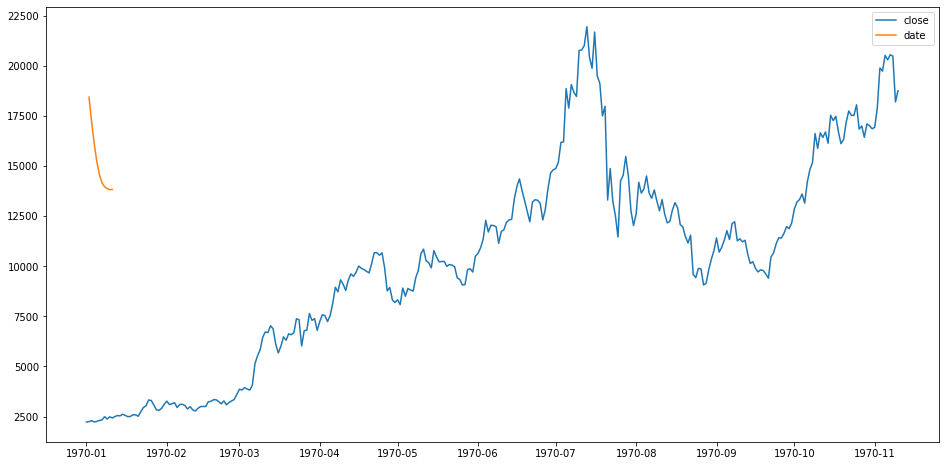

In [106]:
#plocar grafico
plt.figure(figsize=(16, 8))
plt.plot(df_ori['close'])
plt.plot(df_forecast['close'])
plt.legend(['close', 'date'])
plt.show()